# 7 Understanding Simple Recurrent Neural Networks in Keras

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.models import Sequential

## 7.1 Keras `SimpleRNN` Layer

In [103]:
def create_RNN(
    num_hidden_units: int,
    num_dense_units: int,
    input_shape: (int, int),
    activations: [str],
) -> Sequential:
    model = Sequential()
    model.add(
        SimpleRNN(num_hidden_units, input_shape=input_shape, activation=activations[0])
    )
    model.add(Dense(units=num_dense_units, activation=activations[1]))

    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics="RootMeanSquaredError"
    )

    return model


m = 2
T = 3
demo_model = create_RNN(m, 1, (T, 1), activations=["linear", "linear"])

demo_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_27 (SimpleRNN)   (None, 2)                 8         
                                                                 
 dense_27 (Dense)            (None, 1)                 3         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


Why 11 parameters, you ask?

In [3]:
[w.numpy().shape for w in demo_model.layers[0].weights]

[(1, 2), (2, 2), (2,)]

In [4]:
[w.numpy().shape for w in demo_model.layers[1].weights]

[(2, 1), (1,)]

And they are all randomly initialized right now (with the exception of biases which are initialized to zeros).

In [5]:
w_x = demo_model.get_weights()[0]
w_h = demo_model.get_weights()[1]
b_h = demo_model.get_weights()[2]
w_y = demo_model.get_weights()[3]
b_y = demo_model.get_weights()[4]

print(f"{w_x = }\n{w_h = }\n{b_h = }\n{w_y = }\n{b_y = }")

w_x = array([[-1.3690753 , -0.34511125]], dtype=float32)
w_h = array([[-0.8884481 ,  0.45897698],
       [-0.45897698, -0.8884482 ]], dtype=float32)
b_h = array([0., 0.], dtype=float32)
w_y = array([[ 1.3722934 ],
       [-0.35240567]], dtype=float32)
b_y = array([0.], dtype=float32)


Notice how the dimensions of our parameters are independent of the number of time steps. The same weight matrices are used in every time step within the same forward pass.

Next, let us look at a single forward pass in this super-simple model. Recall that "linear" activation functions do nothing as they are the identity function $f(x) = x$.

In [6]:
x = np.array([1, 2, 3])
x_input = np.reshape(x, (1, T, 1))  # 1 sequence, T=3 time steps, 1 feature
y_pred = demo_model.predict(x_input)
y_pred

1/1 [==============================] - 0s 81ms/step


2023-03-30 20:34:44.151133: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[-3.068111]], dtype=float32)

Now let us replicate this result using linear algebra.

In [7]:
h = np.zeros((m, T + 1))
for t in range(T):
    h[:, t + 1] = np.dot(x[t], w_x) + np.dot(h[:, t], w_h) + b_h
o_3 = np.dot(h[:, T], w_y) + b_y
o_3

array([-3.06811105])

💥 BAM! They're equal.

## 7.2 Running the RNN on Sunspots Dataset

Read the data and split it into training and test. The data is originally from https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv

In [71]:
def get_train_test_data(url, split_pct=0.8):
    data = pd.read_csv(url, usecols=[1], engine="python").to_numpy().astype("float32")
    scaler = MinMaxScaler()  # By default, converts to the range (0, 1)
    data = scaler.fit_transform(data)
    data = data.flatten()
    n = len(data)
    split_idx = int(n * split_pct)
    train_data = data[:split_idx]
    test_data = data[split_idx:]

    return train_data, test_data, data


url = (  # Originally: https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv
    "data/monthly-sunspots.csv"
)
train_data, test_data, data = get_train_test_data(url)

Get `(X, y)` pairs where each `y` is the next data point immediately following the corresponding `X`. The next `X` sample will begin with the previous `y`. The samples are therefore non-overlapping and all of the data is used and there is no 'data leakage'.

In [72]:
def get_X_y_pairs(data, n_time_steps):
    """
    Returns (X, y pairs) from the provided data according to the specified time step value,
    where X is an ndarray of shape (n_rows, n_time_steps, 1) and y is of shape (n_rows,)

    Each row (except for the very first one) begins with the previous row's y.

    """
    y_indices = np.arange(n_time_steps, len(data), n_time_steps)
    y = data[y_indices]

    n_rows = len(y)
    X = data[range(n_time_steps * n_rows)]
    X = np.reshape(X, (n_rows, n_time_steps, 1))

    return X, y


time_steps = 12  # Sunspots have a cycle of ~12 months
X_train, y_train = get_X_y_pairs(train_data, time_steps)
X_test, y_test = get_X_y_pairs(test_data, time_steps)

We will now create a model and train it in (stochastic) mini-batches. This is a toy model and we're just experimenting and learning here, so there is no validation set, early stopping, etc.

In [163]:
model = create_RNN(3, 1, (time_steps, 1), ["tanh", "tanh"])

model.fit(X_train, y_train, batch_size=1, epochs=20, verbose=1)

Epoch 1/20
187/187 [==============================] - 0s 761us/step - loss: 0.2719 - root_mean_squared_error: 0.5214
Epoch 2/20
187/187 [==============================] - 0s 690us/step - loss: 0.0728 - root_mean_squared_error: 0.2698
Epoch 3/20
187/187 [==============================] - 0s 704us/step - loss: 0.0461 - root_mean_squared_error: 0.2146
Epoch 4/20
187/187 [==============================] - 0s 663us/step - loss: 0.0343 - root_mean_squared_error: 0.1853
Epoch 5/20
187/187 [==============================] - 0s 646us/step - loss: 0.0275 - root_mean_squared_error: 0.1660
Epoch 6/20
187/187 [==============================] - 0s 657us/step - loss: 0.0225 - root_mean_squared_error: 0.1500
Epoch 7/20
187/187 [==============================] - 0s 651us/step - loss: 0.0189 - root_mean_squared_error: 0.1376
Epoch 8/20
187/187 [==============================] - 0s 657us/step - loss: 0.0156 - root_mean_squared_error: 0.1250
Epoch 9/20
187/187 [==============================] - 0s 656us/s

Here's a function to print the errors:

In [164]:
def print_errors(train_true, test_true, train_pred, test_pred):
    # Error of predictions
    train_rmse = np.sqrt(mean_squared_error(train_true, train_pred.flatten()))
    test_rmse = np.sqrt(mean_squared_error(test_true, test_pred.flatten()))
    # Print RMSE
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")


# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
# Mean squared error
print_errors(y_train, y_test, train_pred, test_pred)

2/2 [==============================] - 0s 1ms/step
Train RMSE: 0.0692
Test RMSE: 0.1094


And another function to plot the predictions against the real values:

In [165]:
y_train.shape

(187,)

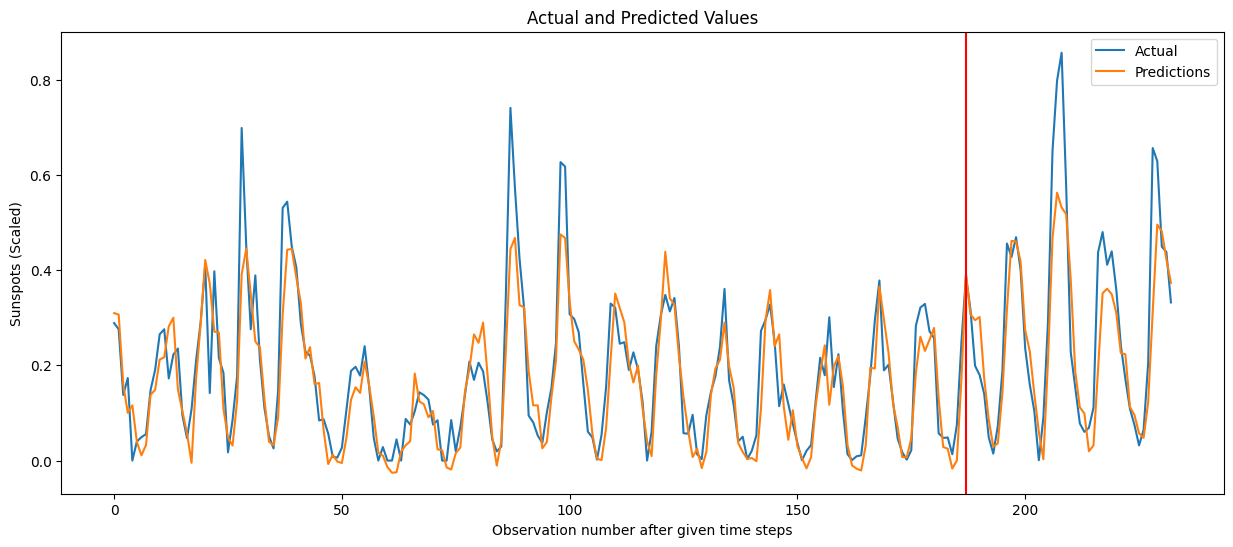

In [166]:
def plot_pred_results(train_true, test_true, train_pred, test_pred):
    actual = np.concatenate((train_true, test_true))
    predictions = np.concatenate((train_pred, test_pred))
    n_train = len(train_true)
    plt.figure(figsize=(15, 6))
    plt.plot(actual)
    plt.plot(predictions)
    plt.axvline(x=n_train, color="r")
    plt.legend(["Actual", "Predictions"])
    plt.xlabel("Observation number after given time steps")
    plt.ylabel("Sunspots (Scaled)")
    plt.title("Actual and Predicted Values")

plot_pred_results(y_train, y_test, train_pred, test_pred)